In [1]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 68% 41.0M/60.3M [00:00<00:00, 213MB/s]
100% 60.3M/60.3M [00:00<00:00, 188MB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

# Import Modules and Packages

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
import tensorflow as tf

from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers,models,regularizers,optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Activation,GlobalAveragePooling2D,Input
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17116\1341516879.py:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# Setting up directory to save model data

In [5]:
# Define project name
project_name = 'Facial Emotion Detection'

# List all models
model_name = [
    'Custom CNN - Data Augmentation',
    'VGG16 - Transfer Learning',
    'ResNet50 - Transfer Learning'
]

# Base Directory (For using google colab)
base_dir = '/content/'

# create the project directory
project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)

# create folders for each directory in the project directory
for model in model_name:
  model_dir = os.path.join(project_dir,model)
  os.makedirs(model_dir,exist_ok=True)

# Data Cleaning

In [6]:
img_exts = ['jpeg', 'jpg', 'png']

path_dir = '/content/train'

for root,dirs,files in os.walk(path_dir):
  for file in files:
    file_path = os.path.join(root,file)
    try:
      file_type = imghdr.what(file_path)
      if file_type not in img_exts:
        print(f'Image not in exist list {file_path}')
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)
    except Exception as e:
      print(f'Issue with image {file_path}. Error : {e}')
      os.remove(file_path)

# Data Analysis

In [7]:
# Count all images in each folder
def count_files_in_subdir(directory,set_name):
  counts={}
  for item in os.listdir(directory):
    item_path = os.path.join(directory,item)
    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))

  df = pd.DataFrame(counts,index=[set_name])
  return df

# Paths to the train & test directory
train_dir = '/content/train'
test_dir = '/content/test'

train_counts = count_files_in_subdir(train_dir,'train')
test_counts = count_files_in_subdir(test_dir,'test')
print(train_counts)
print()
print(test_counts)

       angry  neutral  fear  happy   sad  disgust  surprise
train   3995     4965  4097   7215  4830      436      3171

      angry  neutral  fear  happy   sad  disgust  surprise
test    958     1233  1024   1774  1247      111       831


<Axes: >

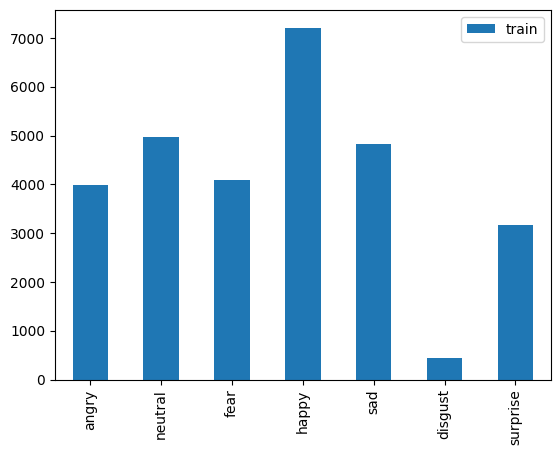

In [8]:
train_counts.transpose().plot(kind='bar')

<Axes: >

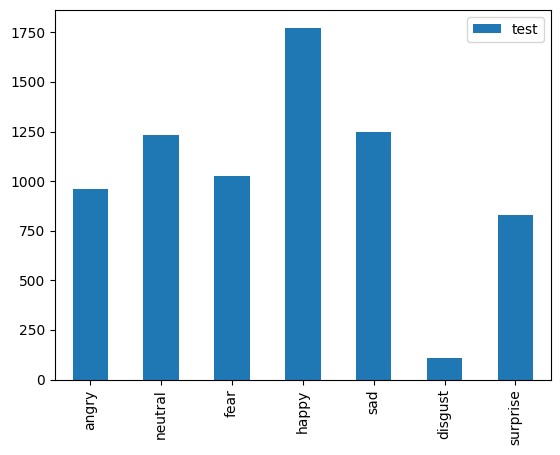

In [9]:
test_counts.transpose().plot(kind='bar')

# Ploting one image from each emotion

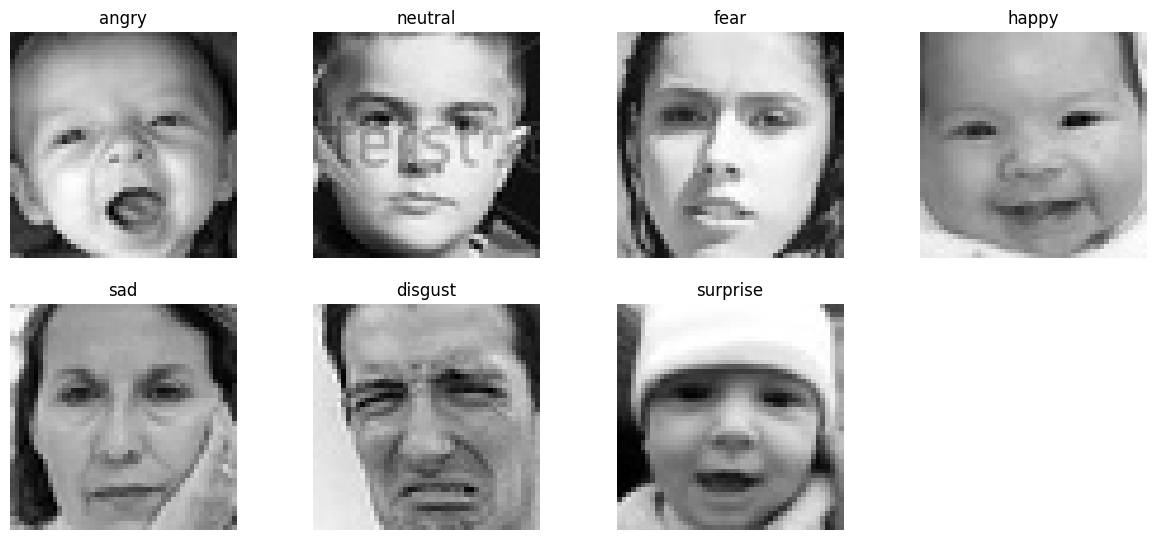

In [10]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i,emotion in enumerate(emotions,1):
  folder = os.path.join(train_dir,emotion)
  img_path = os.path.join(folder,os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img,cmap='gray')
  plt.title(emotion)
  plt.axis('off')

# Ploting random images from given directory

In [11]:
def plot_images_from_directory(directory,label,num_images=9):
  image_filenames = os.listdir(directory)
  selected_images = random.sample(image_filenames,num_images)

  fig,axes = plt.subplots(3,3,figsize=(5,5))
  axes = axes.ravel()

  for i,img_file in enumerate(selected_images):
    image_path = os.path.join(directory,img_file)
    image = load_img(image_path)
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

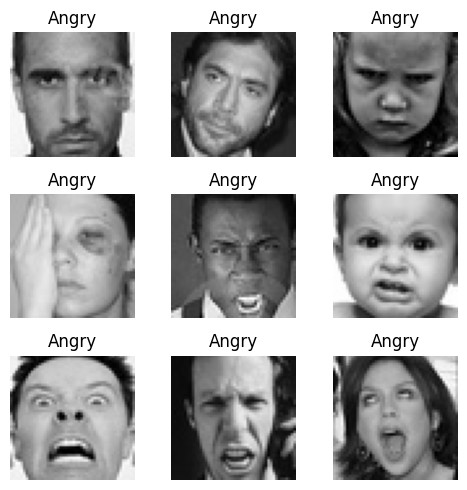

In [12]:
plot_images_from_directory('/content/train/angry','Angry')

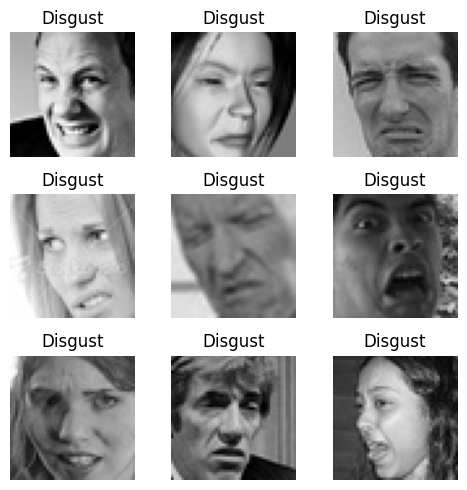

In [13]:
plot_images_from_directory('/content/train/disgust','Disgust')

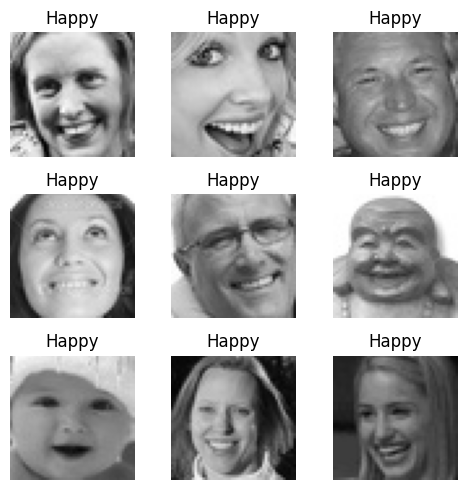

In [14]:
plot_images_from_directory('/content/train/happy','Happy')

# Checking the shape & Channels

In [15]:
image = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image)
img.shape

(48, 48, 3)

In [16]:
image = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
img.shape

(48, 48)

# Model - 1 building (Custom CNN - Data Augmentation)

In [ ]:
# Define the directory
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
# Set some parameters
img_height,img_width = 48,48
batch_size = 64
epochs = 10
num_classes = 7

In [ ]:
# Rescale the pixel value [0 - 255] to [0 - 1]
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation)
)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Automatically retrieve images and their classes for train and validation set
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)


test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Accessing class lebels for tarin & validation data
train_class_lebel = train_generator.class_indices
print(f'Train class lebel : {train_class_lebel}')

validation_class_lebel = validation_generator.class_indices
print(f'validation class lebel : {validation_class_lebel}')

Train class lebel : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
validation class lebel : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Initializing the CNN
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.L2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3,3), kernel_regularizer=regularizers.L2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.L2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.L2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │              

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/Facial Emotion Detection/Custom CNN - Data Augmentation'
name = 'CNN_emotion_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callbacks to save the model checkpoint
checkpoint = ModelCheckpoint(
    filepath = chk_path,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1,
    mode = 'min'
)

# Callback for early stopping
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1,
    min_delta = 0.0001
)

callbacks = [checkpoint,earlystop,reduce_lr]

# Calculating steps for epochs

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
#validation_steps_per_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_per_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
# Model Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    #validation_steps=validation_steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2059 - loss: 13.3829
Epoch 1: val_loss improved from inf to 14.19654, saving model to /content/Facial Emotion Detection/Custom CNN - Data Augmentation/CNN_emotion_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 68s 144ms/step - accuracy: 0.2060 - loss: 13.3803 - val_accuracy: 0.1683 - val_loss: 14.1965 - learning_rate: 1.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 14.19654 to 14.18728, saving model to /content/Facial Emotion Detection/Custom CNN - Data Augmentation/CNN_emotion_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1683 - val_loss: 14.1873 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2429 - loss: 10.6905
Epoch 3: val_loss improved from 14.18728 to 9.77301, saving model to /content/Facial Emotion Detection/Custom CNN - Data Augmentation/CNN_emotion_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s

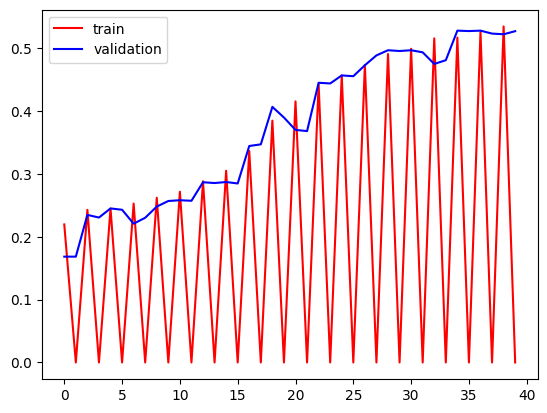

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

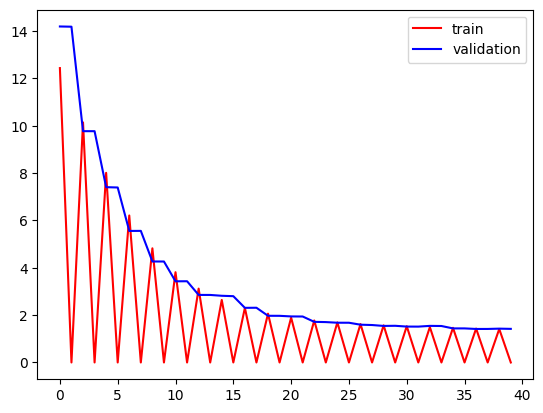

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# Model Evaluation

In [ ]:
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)
print(f'Final Train accuracy : {train_accu*100} , Final Test accuracy : {test_accu*100}')

359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.5488 - loss: 1.3760
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5729 - loss: 1.3059
Final Train accuracy : 54.175376892089844 , Final Test accuracy : 57.105040550231934


# Plotting Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


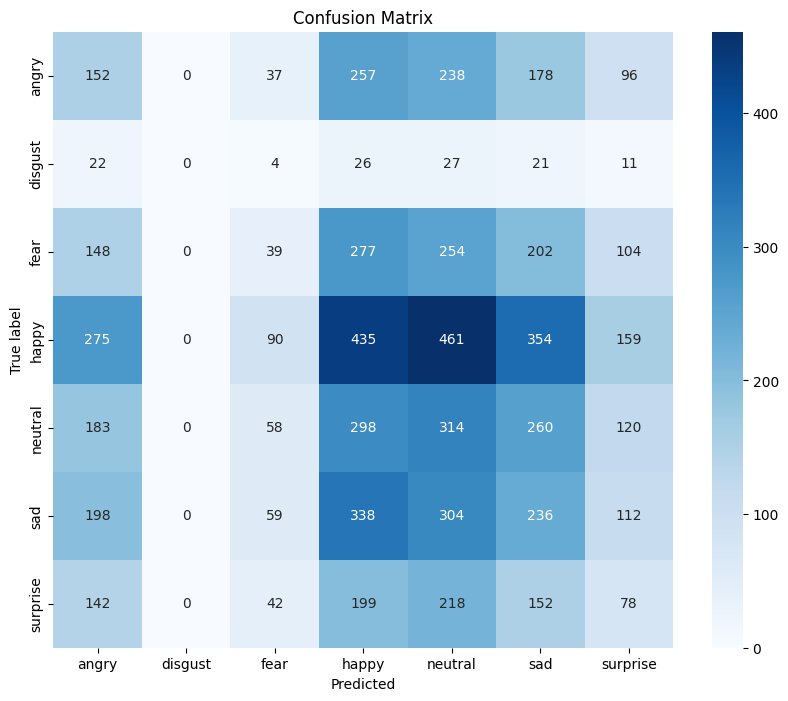

In [ ]:
true_classes = test_generator.classes
predict_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_lebels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predict_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_lebels, yticklabels=class_lebels)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(true_classes, predict_classes, target_names=class_lebels))

              precision    recall  f1-score   support

       angry       0.14      0.16      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.12      0.04      0.06      1024
       happy       0.24      0.25      0.24      1774
     neutral       0.17      0.25      0.21      1233
         sad       0.17      0.19      0.18      1247
    surprise       0.11      0.09      0.10       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.17      7178



# Making Predictions

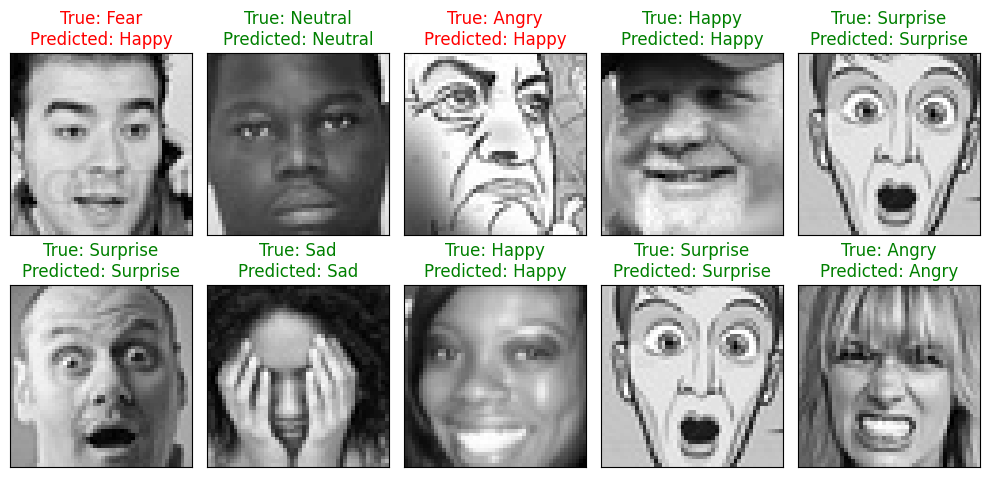

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model - VGG16 (Transfer Learning)

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

img_width, img_height = 224, 224
batch_size = 64
epochs = 10
num_classes = 7

data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_preprocessor = ImageDataGenerator(rescale=1./255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True
)

test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Define class weight for imbalance data
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
classes = 7

# Clear the previous all tensorflow session
tf.keras.backend.clear_session()

# Load the VGG16 base model excluding the top (Dense) layers
vgg = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Make the specific (Dense) layers non-trainable
for layer in vgg.layers[:-3]:
  layer.trainable = False

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
# add Flatten layer
x = Flatten()(vgg.output)

# adding all Dense layer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

# add output layer
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# create & compile the model
model = Model(inputs=vgg.input, outputs=output)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 30,939,143 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/Facial Emotion Detection/VGG16 - Transfer Learning'
name = 'CNN_emotion_model_VGG16.keras'
chk_path = os.path.join(cnn_path, name)

# Callbacks to save the model checkpoint
checkpoint = ModelCheckpoint(
    filepath = chk_path,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1,
    mode = 'min'
)

# Callback for early stopping
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1,
    min_delta = 0.0001
)

callbacks = [checkpoint,earlystop,reduce_lr]

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
#test_steps_per_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=test_generator,
    #validation_steps=test_steps_per_epoch,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.2250 - loss: 1.9633
Epoch 1: val_loss improved from inf to 1.60734, saving model to /content/Facial Emotion Detection/VGG16 - Transfer Learning/CNN_emotion_model_VGG16.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 467s 959ms/step - accuracy: 0.2252 - loss: 1.9630 - val_accuracy: 0.3802 - val_loss: 1.6073 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss did not improve from 1.60734
449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3802 - val_loss: 1.6073 - learning_rate: 1.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.3767 - loss: 1.6149
Epoch 3: val_loss improved from 1.60734 to 1.38106, saving model to /content/Facial Emotion Detection/VGG16 - Transfer Learning/CNN_emotion_model_VGG16.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 411s 903ms/step - accuracy: 0.3768 - loss: 1.6148 - val_accuracy: 0.4759 - val_loss: 1.3811 - learning_rate: 1.0000e-04


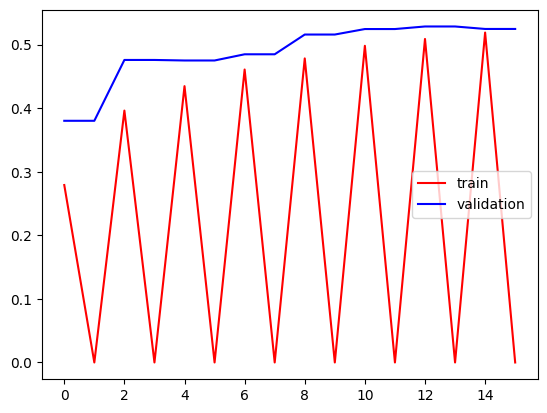

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

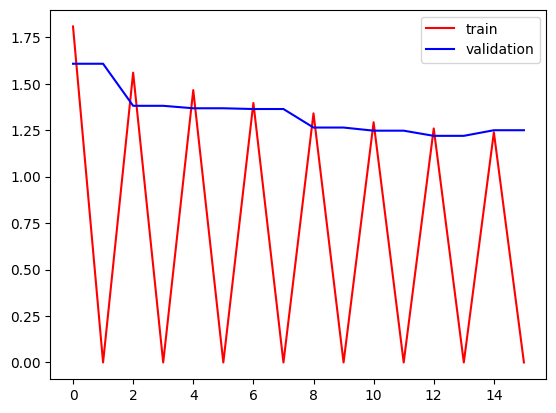

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Model Evaluation
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)
print(f'Final Train accuracy : {train_accu*100} , Final Test accuracy : {test_accu*100}')

449/449 ━━━━━━━━━━━━━━━━━━━━ 368s 817ms/step - accuracy: 0.5344 - loss: 1.2237
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 260ms/step - accuracy: 0.5299 - loss: 1.2161
Final Train accuracy : 53.216761350631714 , Final Test accuracy : 52.855950593948364


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 259ms/step


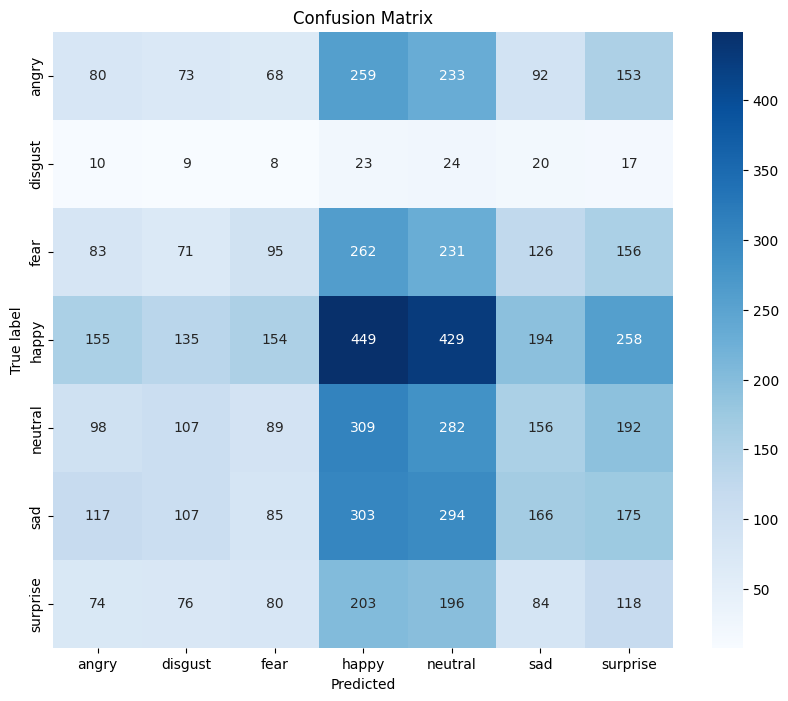

In [ ]:
# Confusion matrix
true_classes = test_generator.classes
predict_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_lebels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predict_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_lebels, yticklabels=class_lebels)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(true_classes, predict_classes, target_names=class_lebels))

              precision    recall  f1-score   support

       angry       0.13      0.08      0.10       958
     disgust       0.02      0.08      0.03       111
        fear       0.16      0.09      0.12      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.20      0.13      0.16      1247
    surprise       0.11      0.14      0.12       831

    accuracy                           0.17      7178
   macro avg       0.15      0.14      0.14      7178
weighted avg       0.18      0.17      0.17      7178



# Model - ResNet50 (Transfer Learning)

In [17]:
train_dir = '/content/train'
test_dir = '/content/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
# Including Class Weights for imbalance data
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [19]:
def create_model(input_shape, num_classes):
    # Define the input tensor
    inputs = Input(shape=input_shape)

    # Load the ResNet50V2 model without the top classification layers
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=inputs)

    # Add custom layers on top of the base model
    x = base_model.output
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define the full model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Define the input shape and number of emotion classes
input_shape = (224, 224, 3)
num_classes = 7

# Create the model
model = create_model(input_shape, num_classes)

# Compile the model with the Adamax optimizer
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 24,787,207 (94.56 MB)

 Trainable params: 24,737,671 (94.37 MB)

 Non-trainable params: 49,536 (193.50 KB)

In [20]:
# File path for the model checkpoint
cnn_path = '/content/Facial Emotion Detection/ResNet50 - Transfer Learning'
name = 'CNN_emotion_model_ResNet50V2.keras'
chk_path = os.path.join(cnn_path, name)

# Callbacks to save the model checkpoint
checkpoint = ModelCheckpoint(
    filepath = chk_path,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1,
    mode = 'min'
)

# Callback for early stopping
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1,
    min_delta = 0.0001
)

callbacks = [checkpoint,earlystop,reduce_lr]

In [21]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=test_generator,
    #validation_steps=100,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.2321 - loss: 1.8924
Epoch 1: val_loss improved from inf to 1.47002, saving model to /content/Facial Emotion Detection/ResNet50 - Transfer Learning/CNN_emotion_model_ResNet50V2.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 529s 517ms/step - accuracy: 0.2321 - loss: 1.8923 - val_accuracy: 0.4634 - val_loss: 1.4700 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss did not improve from 1.47002
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4634 - val_loss: 1.4700 - learning_rate: 1.0000e-04
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4204 - loss: 1.5601
Epoch 3: val_loss improved from 1.47002 to 1.28234, saving model to /content/Facial Emotion Detection/ResNet50 - Transfer Learning/CNN_emotion_model_ResNet50V2.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 425s 471ms/step - accuracy: 0.4205 - loss: 1.5600 - val_accuracy: 0.5132 - val_loss: 1.2823 - learning_r

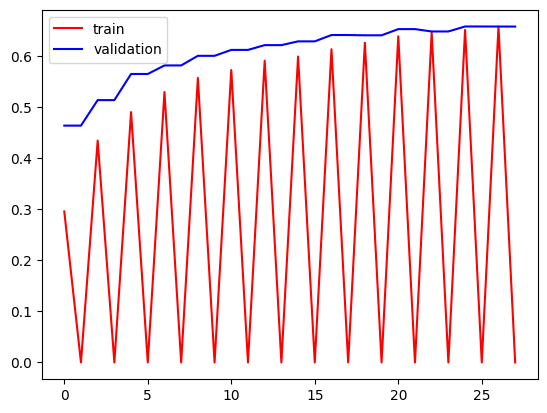

In [23]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

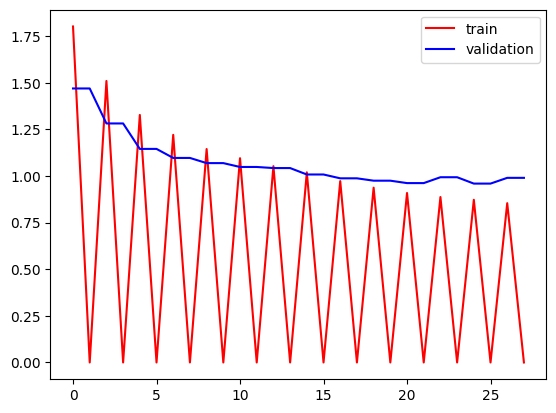

In [24]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [25]:
# Model Evaluation
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)
print(f'Final Train accuracy : {train_accu*100} , Final Test accuracy : {test_accu*100}')

898/898 ━━━━━━━━━━━━━━━━━━━━ 356s 396ms/step - accuracy: 0.6881 - loss: 0.8335
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.6552 - loss: 0.9578
Final Train accuracy : 69.02713179588318 , Final Test accuracy : 65.72861671447754


225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step


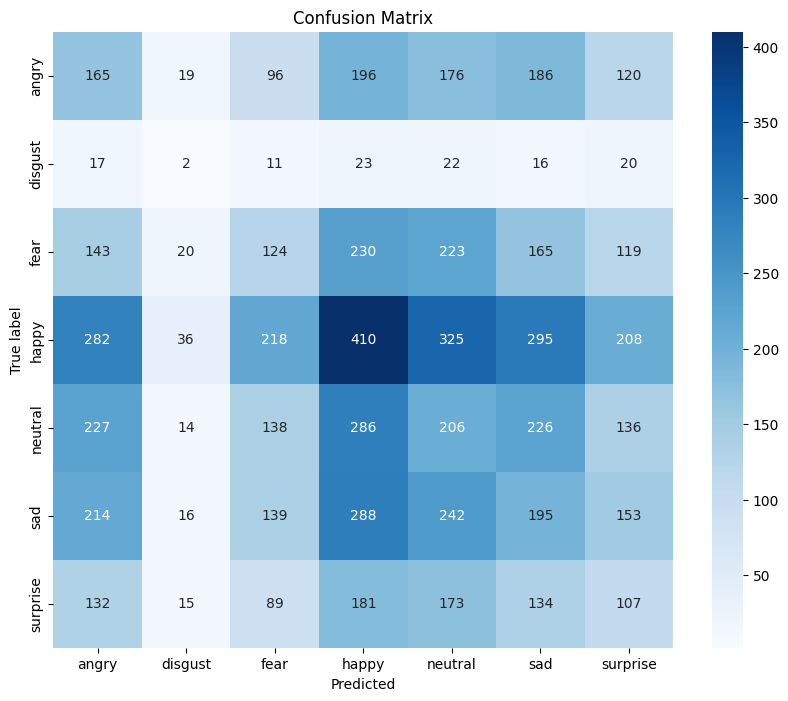

In [26]:
# Confusion matrix
true_classes = test_generator.classes
predict_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_lebels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predict_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_lebels, yticklabels=class_lebels)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()